In [3]:
!pip install tensorflow

In [31]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import os
from PIL import Image
import cv2
import shutil

In [32]:
root_path = '/Users/aungnandaoo/Desktop/ML-in-Prod/4_MachineLearning'
root_path
file_dir = ['fruits/Kiwi','fruits/Pear','fruits/Watermelon']
images = []
file_list = []

for cur_class in file_dir:
    temp_path = root_path+"/"+cur_class
    for cur_file in os.listdir(temp_path): #listdir means gettting all the files inside that path
        read_path = temp_path+"/"+cur_file
        
        img = cv2.imread(read_path)
        img = cv2.resize(img,(224,224))

        images.append(img)
        file_list.append(read_path)

images= np.array(images)
file_list = np.array(file_list)

In [33]:
print("Images shape: ",images.shape)
print("File list shape: ",file_list.shape)

Images shape:  (1401, 224, 224, 3)
File list shape:  (1401,)


# Feature Generate using pretrain model

In [34]:
model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
predictions = model.predict(images.reshape(-1, 224, 224, 3))
features = predictions.reshape(images.shape[0], -1)
print("Features shape", features.shape)

44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step
Features shape (1401, 62720)


# Silhouette Coefficient

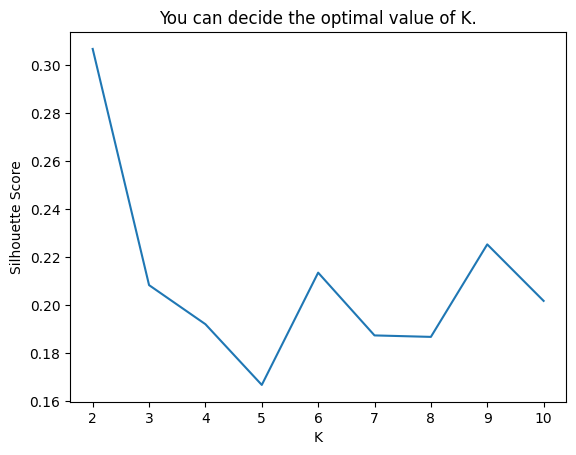

In [66]:
sil = []
kl = []
kmax = 10

for k in range(2, kmax+1):
    kmeans2 = KMeans(n_clusters=k).fit(features)
    labels = kmeans2.labels_
    sil.append(silhouette_score(features, labels, metric='euclidean'))
    kl.append(k)

plt.plot(kl, sil)
plt.ylabel('Silhouette Score')
plt.xlabel('K')
plt.title("You can decide the optimal value of K.")
plt.show()


# Train K-Means Clusting

In [67]:
# Train K-Means Clustering
k = 3
kmodel = KMeans(n_clusters=k, random_state=728)
kmodel.fit(features)


KMeans(n_clusters=3, random_state=728)

# Test Model

In [68]:
# Load test images
test_path = "/Users/aungnandaoo/Desktop/ML-in-Prod/4_MachineLearning/fruits/testset"
test_images = []
test_files = []

for cur_file in os.listdir(test_path):
    read_path = test_path + "/" + cur_file
    img = cv2.imread(read_path)
    img = cv2.resize(img, (224, 224))
    test_images.append(img)
    test_files.append(read_path)

test_images = np.array(test_images)
test_files = np.array(test_files)

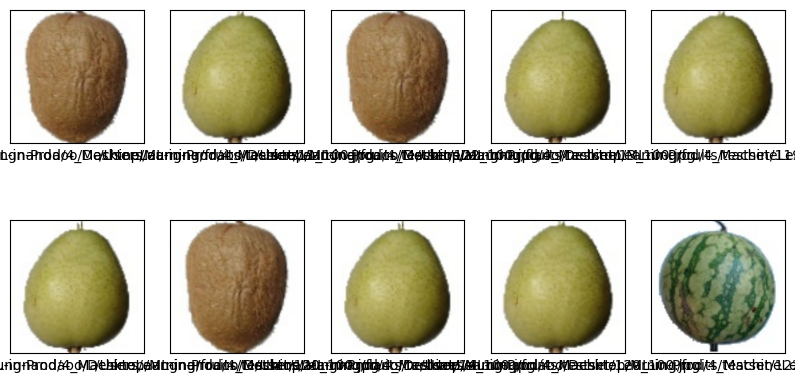

In [69]:
plt.figure(figsize=(10, 5))
random_inds = np.random.choice(range(len(test_images)), 10)

for i, img_i in enumerate(random_inds):
    plt.subplot(2, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    show_image = cv2.cvtColor(test_images[img_i], cv2.COLOR_BGR2RGB)
    plt.imshow(np.squeeze(show_image))
    plt.xlabel(test_files[img_i])

In [70]:
print("test_images shape: ", test_images.shape)
print("test_files list shape: ", test_files.shape)

test_images shape:  (12, 224, 224, 3)
test_files list shape:  (12,)


In [71]:
# Generate features from test set
test_predictions = model.predict(test_images.reshape(-1, 224, 224, 3))
test_features = test_predictions.reshape(test_images.shape[0], -1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


In [72]:
# Cluster the features
kpredictions = kmodel.predict(test_features)
kpredictions

array([2, 0, 1, 1, 2, 0, 2, 0, 1, 2, 1, 0], dtype=int32)

In [79]:
for i, (prediction, file) in enumerate(zip(kpredictions, test_files)):
    print(f"File: {file}, Cluster: {prediction}")

cluster_to_fruit = {
    0: "Kiwi",
    1: "Watermelon",
    2: "Pear"
}


File: /Users/aungnandaoo/Desktop/ML-in-Prod/4_MachineLearning/fruits/testset/121_100.jpg, Cluster: 2
File: /Users/aungnandaoo/Desktop/ML-in-Prod/4_MachineLearning/fruits/testset/11_100.jpg, Cluster: 0
File: /Users/aungnandaoo/Desktop/ML-in-Prod/4_MachineLearning/fruits/testset/73_100.jpg, Cluster: 1
File: /Users/aungnandaoo/Desktop/ML-in-Prod/4_MachineLearning/fruits/testset/72_100.jpg, Cluster: 1
File: /Users/aungnandaoo/Desktop/ML-in-Prod/4_MachineLearning/fruits/testset/120_100.jpg, Cluster: 2
File: /Users/aungnandaoo/Desktop/ML-in-Prod/4_MachineLearning/fruits/testset/12_100.jpg, Cluster: 0
File: /Users/aungnandaoo/Desktop/ML-in-Prod/4_MachineLearning/fruits/testset/122_100.jpg, Cluster: 2
File: /Users/aungnandaoo/Desktop/ML-in-Prod/4_MachineLearning/fruits/testset/13_100.jpg, Cluster: 0
File: /Users/aungnandaoo/Desktop/ML-in-Prod/4_MachineLearning/fruits/testset/74_100.jpg, Cluster: 1
File: /Users/aungnandaoo/Desktop/ML-in-Prod/4_MachineLearning/fruits/testset/119_100.jpg, Cluster

In [80]:
kiwi_path = "result/Kiwi"
pear_path = "result/Pear"
watermelon_path = "result/Watermelon"
other_path = "result/others"

os.makedirs(kiwi_path, exist_ok=True)
os.makedirs(pear_path, exist_ok=True)
os.makedirs(watermelon_path, exist_ok=True)
os.makedirs(other_path, exist_ok=True)

In [81]:
for i, img in enumerate(test_images):
    fruit = cluster_to_fruit[kpredictions[i]]
    if fruit == "Kiwi":
        cv2.imwrite(kiwi_path + "/" + str(i) + ".jpg", img)
    elif fruit == "Pear":
        cv2.imwrite(pear_path + "/" + str(i) + ".jpg", img)
    elif fruit == "Watermelon":
        cv2.imwrite(watermelon_path + "/" + str(i) + ".jpg", img)
    else:
        cv2.imwrite(other_path + "/" + str(i) + ".jpg", img)
